<a href="https://colab.research.google.com/github/alexDahersh/Data-Science-fund./blob/main/Alex_HershU9Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Predicting Non-Firearm Suicides

Last project, I investigated why suicide rates were strongly related to how Republican a county voted. As it turned out, the asnwer was there were more firearm suicides in Republican counties. In this project I'm going to investigate what causes non-firearm suicides.

# Assumptions

Although I've already done a project on suicides, I am not too knowledgeable about this subject. My last project was about a slightly different category of suicides so my takeaway from that project may not be too useful. What I do know is that how Republican a country votes is not strongly related to non-firearm suicides. As can be seen from the image below, the R^2 between percent Republican and non-firearm suicides is low.

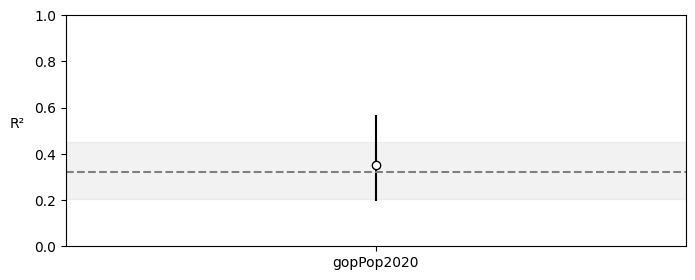

I'm going to be using neural networks for this project. My general strategy (for my main neural network) will be going from a few hidden nodes in a layer to a lot then shrinking to small numbers of nodes. I'm going to assume this is a reasonable strategy and won't lead to any biases or problems with the model.

I'm also going to assume my predictors makes sense. I think population may affect suicide rates. Urban areas create different environments than rural areas which may lead to a difference in suicides. Average income may also be an indication for suicide rates. I believe poverty increases suicide rates and average income greatly affects poverty. For the same reason povert rate is an indication for suicide rates. I also think mental unhealth causes suicides, so average number of mentally unhealthy days is a good indicator for suicides. Lastly, from the last project I found that suicide rates are a lot higher in men. Percent male then should also be a reasonable predictor for suicide rates.

I'm also going to assume MSELoss works well.

# Data

I'm inverting the suicide rates. I'm not sure if this helps at all, but I was having problems when it wasn't inverted. Lower values mean higher suicide rates now.

In [10]:
counties = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/counties.csv') # getting my data

In [11]:
counties = counties[(counties['deaths/suicides'] - counties['deaths/firearm suicides']) != 0].copy()

In [12]:
sui_rate = counties['population/2019'] / (counties['deaths/suicides'] - counties['deaths/firearm suicides']) / 10_000 # what I'll be predicting
counties.insert(counties.shape[1], "sui_rate", sui_rate) # putting suicide rates into the dataframe

In [75]:
male_per = counties['male']/counties['population/2019']
counties.insert(counties.shape[1], "male_per", male_per) # putting male_per into the dataframe

In [76]:
counties.dropna(subset=['sui_rate', 'avg_income', 'poverty-rate', 'health/Average Number of Mentally Unhealthy Days', 'male'], inplace=True) # Removing Nan values

(array([7.000e+01, 1.019e+03, 1.027e+03, 4.300e+02, 1.490e+02, 6.600e+01,
        2.300e+01, 1.800e+01, 8.000e+00, 7.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.23593784,  0.95726324,  1.67858865,  2.39991405,  3.12123946,
         3.84256486,  4.56389027,  5.28521568,  6.00654108,  6.72786649,
         7.44919189,  8.1705173 ,  8.8918427 ,  9.61316811, 10.33449351,
        11.05581892, 11.77714432, 12.49846973, 13.21979514, 13.94112054,
        14.66244595, 15.38377135, 16.10509676, 16.82642216, 17.54774757,
        18.26907297, 18.99039838, 19.71172378, 20.43304919, 21.15437459,
        21.8757    ]),
 <BarContainer object of 30 artists>)

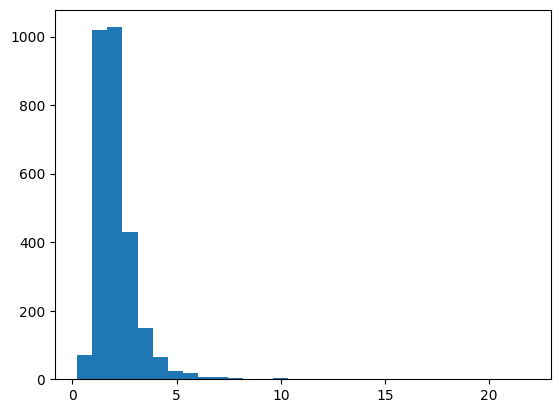

In [77]:
plt.hist(sui_rate, bins=30) # shows distribution of suicide rates

Suicide rates looks like a gamma distribution, but that doesn't matter because I'm using a neural network.

# Models

I'm going to be running a few models using connections from my assumptions

## First model

Since the setup of the neural network is fairly significant, I will try two different neural networks with the same variables. This first one is my attempt at simplicity.

In [79]:
# I took this code from the AI section of the notes and then used AI to get it formatted right

features = counties[['avg_income', 'population/2019', 'poverty-rate', 'health/Average Number of Mentally Unhealthy Days', 'male_per']]
target = counties['sui_rate']


# Scale the height using standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.values)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)

# Convert NumPy arrays and pandas Series to PyTorch tensors AFTER splitting
X_train = torch.tensor(X_train, dtype=torch.float32)
# Convert y_train (which is a pandas Series after split) to a tensor
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
# Convert y_test (which is a pandas Series after split) to a tensor
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [80]:

model_1 = nn.Sequential(
    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=5, out_features=8,),
    nn.Tanh(),

    #moves to hidden layer with 16 nodes
    nn.Linear(in_features=8, out_features=4, ),
    nn.Tanh(),

    #hidden layer with 8 nodes
    nn.Linear(in_features=4, out_features=2, ),
    nn.Tanh(),

    #hidden layer with 4 nodes
    nn.Linear(in_features=2, out_features=1, ),
    #outputs a vector of predicted weights
)


In [81]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.003) #this is how fast it optimizes; smaller is slower, but more consistent

In [82]:
# Set the number of epochs; this is how many times we update our model
epochs = 100000 # This makes sure the model isn't getting better

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_1(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 2000 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.7f}, Test loss: {test_loss:.7f}")

Epoch: 0 | Train loss: 5.2423239, Test loss: 4.5502152
Epoch: 2000 | Train loss: 1.2646616, Test loss: 0.7446511
Epoch: 4000 | Train loss: 1.2165952, Test loss: 0.7204815
Epoch: 6000 | Train loss: 1.1869605, Test loss: 0.7078594
Epoch: 8000 | Train loss: 1.1672587, Test loss: 0.7021607
Epoch: 10000 | Train loss: 1.1491010, Test loss: 0.6987299
Epoch: 12000 | Train loss: 1.1301249, Test loss: 0.6987346
Epoch: 14000 | Train loss: 1.1142088, Test loss: 0.7047707
Epoch: 16000 | Train loss: 1.1034038, Test loss: 0.7133870
Epoch: 18000 | Train loss: 1.0957036, Test loss: 0.7207566
Epoch: 20000 | Train loss: 1.0896646, Test loss: 0.7262807
Epoch: 22000 | Train loss: 1.0844560, Test loss: 0.7304094
Epoch: 24000 | Train loss: 1.0797582, Test loss: 0.7338909
Epoch: 26000 | Train loss: 1.0755396, Test loss: 0.7373416
Epoch: 28000 | Train loss: 1.0716923, Test loss: 0.7409267
Epoch: 30000 | Train loss: 1.0680106, Test loss: 0.7445561


KeyboardInterrupt: 

I stopped the model since it didn't seem to be improving. It was getting a higher test loss so it could have been starting to overfit.

I ran this model before using the number of males instead of the percent of males. Running it with percent of males lowered the train loss by about .6. I'm unsure if this is random or if this means male_per is important.

In [83]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_1(X_test)


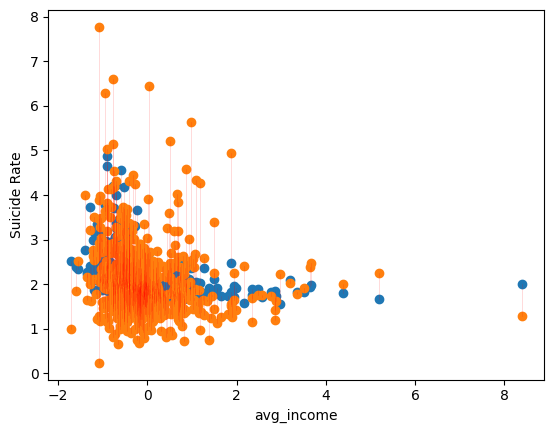

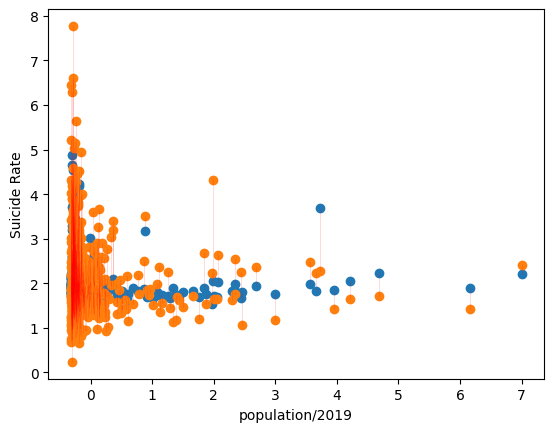

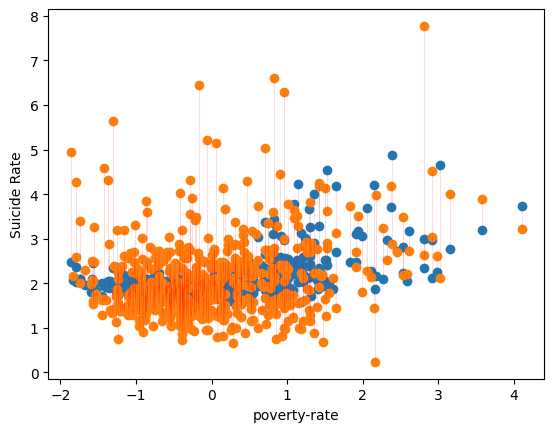

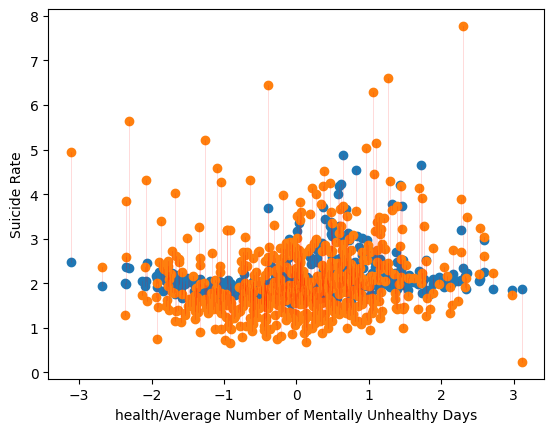

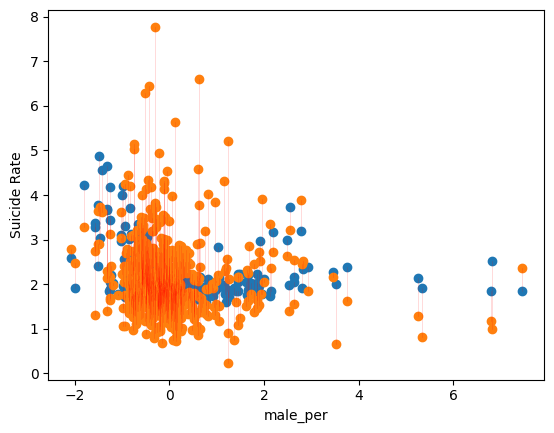

In [84]:
features_str = ['avg_income', 'population/2019', 'poverty-rate', 'health/Average Number of Mentally Unhealthy Days', 'male_per']

for arr_val in range(5):
  fig, ax = plt.subplots()
  for i in range(len(y_preds.detach().numpy())): # adding lines between prediction
      x_line = [X_test[:, arr_val].detach().numpy()[i]] * 2
      y_line = [y_test.detach().numpy()[i], y_preds.detach().numpy()[i]]
      ax.plot(x_line, y_line, c='red', linewidth=0.5, alpha= .2)

  ax.set_xlabel(features_str[arr_val])
  ax.set_ylabel('Suicide Rate')

  ax.scatter(X_test[:, arr_val].detach().numpy(), y_preds.detach().numpy()) # plots predictions (in blue)

  ax.scatter(X_test[:, arr_val].detach().numpy(), y_test.detach().numpy()) # plots data (in orange)

The predictions seem to be okay. The faint red line between points shows how far off the prediction is. The predictions (the blue points) seem to vary at the same x-value so the model has interaction. It is unclear how this interaction plays out though.

Most of the variables themselves seem to not have a strong relationship with suicide rate. Most of the neural networks predicting power seems to come from interaction. The one obvious exception to this is poverty-rate. What is interesting though is that as poverty-rate goes up, the number of suicides goes down (remember that suicide rate was inverted).

The most extreme predictions for suicide rate seem to come from low male percents. This goes against the fact that males kill themselves at a much higher rate. My guess for why this is happening is that it's caused with interaction with some other variable.

## This is my second model using the same predictors. I am using more hidden layers in hopes that the neural network can find more complexity in the data.

In [98]:
# I took this code from the AI section of the notes and then used AI to get it formatted right

features = counties[['avg_income', 'population/2019', 'poverty-rate', 'health/Average Number of Mentally Unhealthy Days', 'male_per']]
target = counties['sui_rate']


# Scale the height using standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.values)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)

# Convert NumPy arrays and pandas Series to PyTorch tensors AFTER splitting
X_train = torch.tensor(X_train, dtype=torch.float32)
# Convert y_train (which is a pandas Series after split) to a tensor
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
# Convert y_test (which is a pandas Series after split) to a tensor
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [99]:
# this model has 4 more layers than the previous model. The layers just alternate between big and small
model_1 = nn.Sequential(
    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=5, out_features=8,),
    nn.Tanh(),

    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=8, out_features=16,),
    nn.Tanh(),

    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=16, out_features=8,),
    nn.Tanh(),

    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=8, out_features=16,),
    nn.Tanh(),

    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=16, out_features=8,),
    nn.Tanh(),

    #moves to hidden layer with 16 nodes
    nn.Linear(in_features=8, out_features=4, ),
    nn.Tanh(),

    #hidden layer with 8 nodes
    nn.Linear(in_features=4, out_features=2, ),
    nn.Tanh(),

    #hidden layer with 4 nodes
    nn.Linear(in_features=2, out_features=1, ),
    #outputs a vector of predicted weights
)


In [102]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.003) #this is how fast it optimizes; smaller is slower, but more consistent

In [103]:
# Set the number of epochs; this is how many times we update our model
epochs = 100000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_1(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 2000 == 0: #prints every 2000 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.7f}, Test loss: {test_loss:.7f}")

Epoch: 0 | Train loss: 1.0325155, Test loss: 0.7718078
Epoch: 2000 | Train loss: 1.0241032, Test loss: 0.7672293
Epoch: 4000 | Train loss: 1.0224497, Test loss: 0.7671734
Epoch: 6000 | Train loss: 1.0207942, Test loss: 0.7667709
Epoch: 8000 | Train loss: 1.0190722, Test loss: 0.7661664


KeyboardInterrupt: 

Epoch 0 has good loss because I messing around with changing learning rate. In total, the model has ran about 30000 epochs. This model got a much better training loss. It's test loss is worse though. This may be a case of overfitting, but I am entirely unsure.

In [104]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_1(X_test)


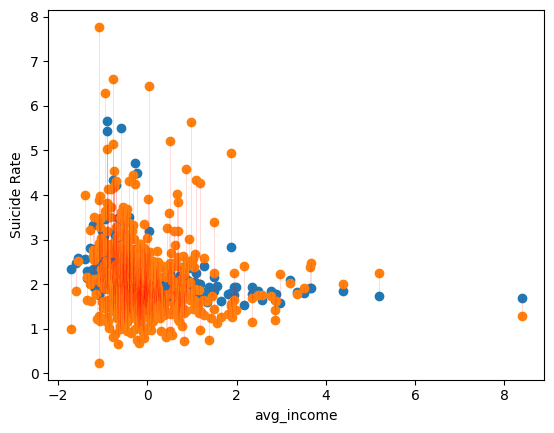

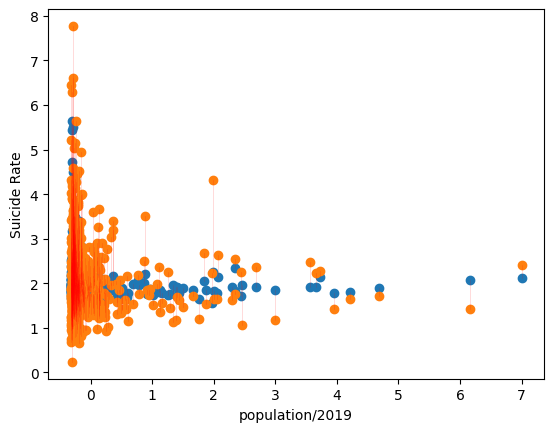

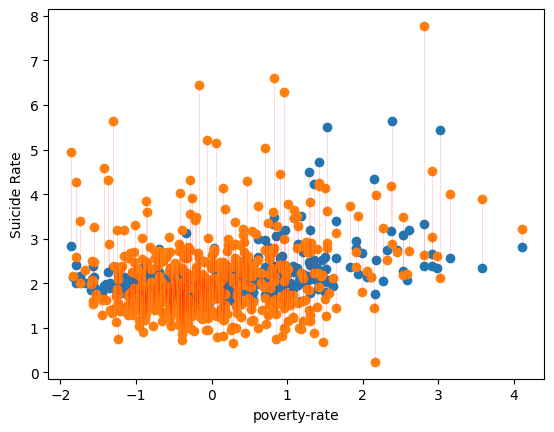

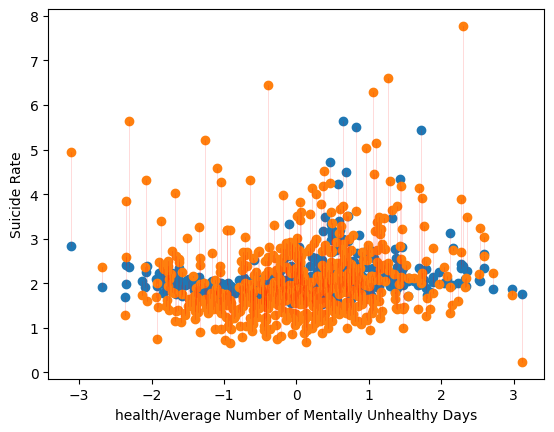

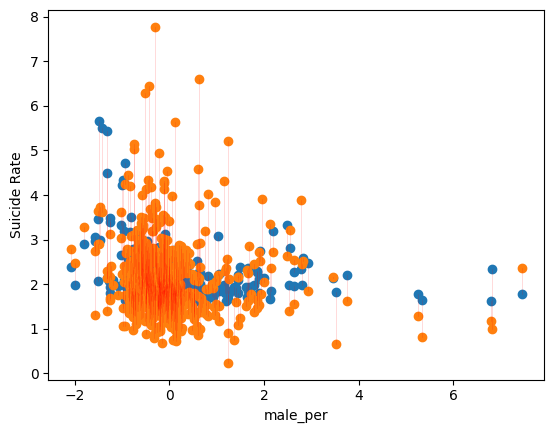

In [105]:
features_str = ['avg_income', 'population/2019', 'poverty-rate', 'health/Average Number of Mentally Unhealthy Days', 'male_per']

for arr_val in range(5):
  fig, ax = plt.subplots()
  for i in range(len(y_preds.detach().numpy())): # adding lines between prediction
      x_line = [X_test[:, arr_val].detach().numpy()[i]] * 2
      y_line = [y_test.detach().numpy()[i], y_preds.detach().numpy()[i]]
      ax.plot(x_line, y_line, c='red', linewidth=0.5, alpha= .2)

  ax.set_xlabel(features_str[arr_val])
  ax.set_ylabel('Suicide Rate')

  ax.scatter(X_test[:, arr_val].detach().numpy(), y_preds.detach().numpy()) # plots predictions (in blue)

  ax.scatter(X_test[:, arr_val].detach().numpy(), y_test.detach().numpy()) # plots data (in orange)

I honestly can't see much of a difference between this model and the last. I'm guessing that the models are essentially the same, and the extra hidden layers were unnecessary. This may not be the case though, but I'm just not sure.

## Analysis

I have no clue how well the model did. My guess is that it is slightly better than a polynomial model with no interaction would be, but I'm unsure. Adding complexity to the model also didn't seem to significantly improve the model. The loss for the second model was lower but the second model trained for longer. I'm also unsure how important each variable was in predicting suicide rates. None of the variables look to have a particulary strong relationship with suicide rate by themselves, but it's unclear how important each variable is in the interaction. My big takeaway from these models is that I don't really understand much about the model or what it's even predicting, but at least I think it did good.

# Conclusion

None of the variables I assumed to have a relationship with suicide rate had a strong relationship with suicide rate by themselves. The neural network did conclude that interaction between these variables existed though. The extent to which different variables participated in the interaction is unclear from the tools I have. The models did better than a model without interaction could do, but how much better is unclear.

I wasn't able to learn much about the relationship between the predictors and target value, but at least I got a model that should hopefully give good predictions.

Looking back at this project, I really wished I transformed the data to be normal. With the way I did it, there are a bunch of points next to 1/2 and some a good bit away. This would have been the same whether I inverted the data or not. This relationship makes the MSE loss function over accomadate for the further data points because they are so far away. In past projects, I could have just used a gamma likelihood to deal with this. Now that there is no likelihood, I'd have to manipulate the data to put more of my knowledge into the model. Maybe I could have also changed the loss function, but I'm not too knowledgable about that.